<div align="center">
    <img src="./OperationNextNest.png" width="400"/><br>
</div>

---

<div align="center">

## 🏡 Operation Next Nest | Part 1 | Data Engineering in Python

</div>

---

Welcome to **Operation Next Nest**!  
In this notebook, we’re playing data detective to help my family find a new neighborhood near the SAS campus in Cary, NC.

**Goal of Part 1 (Python):**

- Pull **U.S. Census block group data** for Wake and Durham Counties  
- Engineer features about:
  - 👶 Kid-friendliness  
  - 🏠 Housing & income  
  - 🚗 Commute to the SAS office  
  - 🌳 Neighborhood amenities (parks, groceries, bike trails)
- Export a clean dataset that we’ll later use in:
  - **Part 2 (SAS)** → scoring + optimization with `PROC OPTMODEL`
  - **Part 3 (R)** → interactive maps

Think of Part 1 as **stocking the pantry** with all of the ingredients we’ll need to “cook up” the best neighborhood recommendations.




***

### 📦 Step 1 | Load Our Python Toolkit

First up: we’ll install and import the Python packages that power Operation Next Nest:

- `censusdata` → pulls ACS data directly from the Census API  
- `pandas` / `numpy` → data wrangling  
- `geopandas` → spatial joins, shapes, and maps  
- `geopy` → distance calculations (how far from SAS HQ?)  
- `osmnx` → pulls neighborhood amenities (parks, groceries, bike trails) from OpenStreetMap  
- `matplotlib` → quick exploratory maps


In [1]:
# If you're in SAS Viya Workbench and this is your first run,
# you may need to install packages once per environment.
# You can comment these out after the first successful run.

!pip install censusdata geopandas matplotlib geopy osmnx --quiet

# Core packages
import censusdata
import pandas as pd
import numpy as np
import geopandas as gpd

from geopy.distance import geodesic
import osmnx as ox
import matplotlib.pyplot as plt

# Jupyter niceties
pd.set_option("display.max_columns", 50)


***

### 🧭 Step 2 | Define Our Study Area

The Groves family wants to stay in the Triangle 🏙️  

(specifically near **SAS Campus** in Cary, NC 👍)

So, we’ll focus on:
- **Wake County** → 183  
- **Durham County** → 063  

These county identifiers (FIPS codes) help us target just the neighborhoods we care about in ACS data.

🌍 Once defined, we’ll soon use these boundaries to:
- Pull Census data only for our region
- Map the neighborhoods in R
- Connect distances and travel times

Let’s set North Carolina and our counties of interest ⬇️


In [2]:
# Specify FIPS codes for North Carolina, Wake, and Durham Counties
STATE_FIPS = "37"     # North Carolina
WAKE_FIPS  = "183"    # Wake County
DURHAM_FIPS = "063"   # Durham County

# ACS 2021 5-year variables at the block group level
# Define block group-level variables to retrieve ==> https://api.census.gov/data/2021/acs/acs5/variables.html
ACS_VARS = [
    'B01001_003E',  # Male under 5 years
    'B01001_027E',  # Female under 5 years
    'B01003_001E',  # Total population
    'B11003_003E',  # Family households with children under 6 years
    'B11001_002E',  # Total family households
    'B11003_002E',  # Households with children under 18
    'B11004_002E',  # Married-couple family households
    'B11004_004E',  # Married-couple with children under 6 years
    'B19013_001E',  # Median household income
    'B25064_001E',  # Median gross rent
    'B25088_002E',  # Median monthly owner costs (with mortgage)
    'B25077_001E',  # Median housing value
    'B25034_001E',  # Median year structure built
    'B25002_003E',  # Vacant housing units
    'B14003_003E',  # Nursery school enrollment
    'B14003_004E',  # Kindergarten enrollment
    'B15003_017E',  # Some college
    'B15003_022E',  # Bachelor’s degree or higher
    'B08013_001E',  # Mean travel time to work (minutes)
    'B25044_003E'   # Households with no vehicle
]


***

### 🧱 Step 3 | Select the Right Census Variables

To compare neighborhoods, we need features that matter for families looking to move.

We will use **American Community Survey (ACS)** 5-year estimates:

| Category | Variable | Why It Matters |
|---------|----------|----------------|
| 💸 Affordability | Median Housing Value, Median Rent | Can we afford to live here? |
| 🏦 Stability | Median Household Income | Stronger economics = stronger communities |
| 👶 Kids & Family Factors | % Households w/ Children Under 6 | Kid-friendly neighborhoods |
| 🌍 Geography | Block group identifiers | Link to maps + travel times |

📌 We will pull **block group-level** data — the most detailed ACS geography!

Everything is tied together using **GEOID**, a unique Census identifier.

Let’s create a dataset for analysis ⬇️


In [3]:
def download_block_groups(county_fips: str) -> pd.DataFrame:
    """
    Download ACS data for all block groups in a given county.
    Returns a DataFrame with a proper 12-digit GEOID.
    """
    df = censusdata.download(
        'acs5', 2021,
        censusdata.censusgeo([
            ('state', STATE_FIPS),
            ('county', county_fips),
            ('block group', '*')
        ]),
        ACS_VARS
    )

    # Reset index to get the geo descriptor
    df = df.reset_index()

    # Build 12-digit GEOID: state(2) + county(3) + tract(6) + block group(1)
    df['GEOID'] = df['index'].apply(
        lambda x: (
            x.geo[0][1].zfill(2) +  # state
            x.geo[1][1].zfill(3) +  # county
            x.geo[2][1].zfill(6) +  # tract
            x.geo[3][1].zfill(1)    # block group
        )
    )

    # Drop the index column
    df = df.drop(columns=['index'])
    return df

wake_data   = download_block_groups(WAKE_FIPS)
durham_data = download_block_groups(DURHAM_FIPS)

# Combine the two counties and then preview the data
census_blockgroup_data = pd.concat([wake_data, durham_data], ignore_index=True)
census_blockgroup_data.head()


,B01001_003E,B01001_027E,B01003_001E,B11003_003E,B11001_002E,B11003_002E,B11004_002E,B11004_004E,B19013_001E,B25064_001E,B25088_002E,B25077_001E,B25034_001E,B25002_003E,B14003_003E,B14003_004E,B15003_017E,B15003_022E,B08013_001E,B25044_003E,GEOID
0,31,25,1203,45,145,134,134,22,97917,1238,2600,504600,664,78,None,None,80,311,None,0,371830501001
1,9,22,2874,18,285,265,265,8,101058,1788,2938,423300,1249,72,None,None,168,626,None,13,371830501002
2,0,0,1110,0,134,107,107,0,109196,1778,1931,395300,1191,427,None,None,36,482,None,0,371830501003
3,0,17,1723,73,250,230,230,18,67536,996,1917,293600,1235,198,None,None,63,650,None,18,371830503001
4,0,0,605,0,35,31,31,0,72083,1259,2526,403400,556,76,None,None,70,184,None,0,371830503002



***

### 📊 Step 4 | Make the Data Human-Friendly

The Census variable codes are… well... not helpful.

So here we:

- Give each column a **descriptive name**  
- Create **percent-based measures** like:
  - `% Children under 5`
  - `% Households with children under 6`
  - `% Married-couple households`
  - `% Married-couple households with young kids`

These will eventually power our “kid-friendly neighborhood” indicator.

In [4]:
# Rename columns for clarity
census_blockgroup_data.columns = [
    'Male under 5', 'Female under 5', 'Total Population',
    'Households with Children under 6', 'Total Family Households',
    'Households with Children under 18',
    'Married-couple Households',
    'Married-couple with Children under 6',
    'Median Household Income', 'Median Gross Rent',
    'Monthly Owner Costs (with mortgage)',
    'Median Housing Value', 'Median Year Structure Built',
    'Vacant Housing Units',
    'Nursery School Enrollment', 'Kindergarten Enrollment',
    'Some College', 'Bachelor’s Degree or Higher',
    'Mean Travel Time to Work', 'Households with No Vehicle',
    'GEOID'
]

# Derived counts and percentages
census_blockgroup_data['Children under 5'] = (
    census_blockgroup_data['Male under 5'] +
    census_blockgroup_data['Female under 5']
)

# Guard against divide-by-zero
census_blockgroup_data['% Children under 5'] = np.where(
    census_blockgroup_data['Total Population'] > 0,
    census_blockgroup_data['Children under 5'] / census_blockgroup_data['Total Population'] * 100,
    np.nan
)

census_blockgroup_data['% Households with Children under 6'] = np.where(
    census_blockgroup_data['Total Family Households'] > 0,
    census_blockgroup_data['Households with Children under 6'] /
    census_blockgroup_data['Total Family Households'] * 100,
    np.nan
)

census_blockgroup_data['% Married-couple Households'] = np.where(
    census_blockgroup_data['Total Family Households'] > 0,
    census_blockgroup_data['Married-couple Households'] /
    census_blockgroup_data['Total Family Households'] * 100,
    np.nan
)

census_blockgroup_data['% Married-couple with Children under 6'] = np.where(
    census_blockgroup_data['Total Family Households'] > 0,
    census_blockgroup_data['Married-couple with Children under 6'] /
    census_blockgroup_data['Total Family Households'] * 100,
    np.nan
)

census_blockgroup_data.head()


,Male under 5,Female under 5,Total Population,Households with Children under 6,Total Family Households,Households with Children under 18,Married-couple Households,Married-couple with Children under 6,Median Household Income,Median Gross Rent,Monthly Owner Costs (with mortgage),Median Housing Value,Median Year Structure Built,Vacant Housing Units,Nursery School Enrollment,Kindergarten Enrollment,Some College,Bachelor’s Degree or Higher,Mean Travel Time to Work,Households with No Vehicle,GEOID,Children under 5,% Children under 5,% Households with Children under 6,% Married-couple Households,% Married-couple with Children under 6
0,31,25,1203,45,145,134,134,22,97917,1238,2600,504600,664,78,None,None,80,311,None,0,371830501001,56,4.655029,31.034483,92.413793,15.172414
1,9,22,2874,18,285,265,265,8,101058,1788,2938,423300,1249,72,None,None,168,626,None,13,371830501002,31,1.078636,6.315789,92.982456,2.807018
2,0,0,1110,0,134,107,107,0,109196,1778,1931,395300,1191,427,None,None,36,482,None,0,371830501003,0,0.000000,0.000000,79.850746,0.000000
3,0,17,1723,73,250,230,230,18,67536,996,1917,293600,1235,198,None,None,63,650,None,18,371830503001,17,0.986651,29.200000,92.000000,7.200000
4,0,0,605,0,35,31,31,0,72083,1259,2526,403400,556,76,None,None,70,184,None,0,371830503002,0,0.000000,0.000000,88.571429,0.000000



***

### 🧭 Step 5 | Add Shapes: Block Group Boundaries

Block groups have **shapes** — not just numbers!

We’ll merge our ACS results with:
- TIGER/Line boundary shapefiles (via `tigris`)
- Coordinate reference system = **WGS84** (EPSG:4326)
  → required for mapping later in R + Leaflet 🌍

This turns our static DataFrame into a **GeoDataFrame** →
now every row knows *where* it is in the world ❤️

Here we:

1. Load the **TIGER/Line block group shapefile** for North Carolina  
2. Filter down to just **Wake and Durham** using county FIPS codes

Let’s attach some geography ⬇️

In [5]:
# Path to the NC block group shapefile
shapefile_path = "./tl_2023_37_bg.shp"

# Load the block group shapefile
gdf = gpd.read_file(shapefile_path)

# Filter for Wake and Durham Counties
gdf = gdf[gdf['COUNTYFP'].isin([WAKE_FIPS, DURHAM_FIPS])]

gdf.head()


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
92,37,063,002019,1,370630020191,1500000US370630020191,Block Group 1,G5030,S,4885136,51127,+35.9033751,-078.9763406,"POLYGON ((-78.98415 35.91174, -78.98394 35.911..."
93,37,063,002020,1,370630020201,1500000US370630020201,Block Group 1,G5030,S,7053910,190334,+35.8836714,-078.9598590,"POLYGON ((-78.97849 35.86682, -78.97764 35.867..."
94,37,063,001806,1,370630018061,1500000US370630018061,Block Group 1,G5030,S,3377611,93260,+36.0054078,-078.8097880,"POLYGON ((-78.82221 35.99619, -78.82158 35.999..."
95,37,063,001808,2,370630018082,1500000US370630018082,Block Group 2,G5030,S,4429008,16941,+35.9626638,-078.8290804,"POLYGON ((-78.84645 35.96563, -78.84617 35.965..."
96,37,063,002024,1,370630020241,1500000US370630020241,Block Group 1,G5030,S,586893,0,+35.9250081,-078.9415460,"POLYGON ((-78.95244 35.9226, -78.9524 35.92261..."



***

### 🔗 Step 6 | Join Attributes to Shapes

Now we glue the two worlds together:

- `census_blockgroup_data` → attributes (income, kids, housing, etc.)  
- `gdf` → geometries (block group polygons)

Using `GEOID` as our key, we create `merged_gdf`, a **GeoDataFrame** that knows both _where_ each block group is and _what_ it looks like demographically.


In [6]:
# Ensure GEOID is a string on both sides
gdf['GEOID'] = gdf['GEOID'].astype(str)
census_blockgroup_data['GEOID'] = census_blockgroup_data['GEOID'].astype(str)

# Merge attributes + geometry
merged_gdf = gdf.merge(
    census_blockgroup_data,
    on='GEOID',
    how='left'
)

merged_gdf = merged_gdf.set_geometry('geometry')
merged_gdf.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Male under 5,Female under 5,Total Population,Households with Children under 6,Total Family Households,Households with Children under 18,Married-couple Households,Married-couple with Children under 6,Median Household Income,Median Gross Rent,Monthly Owner Costs (with mortgage),Median Housing Value,Median Year Structure Built,Vacant Housing Units,Nursery School Enrollment,Kindergarten Enrollment,Some College,Bachelor’s Degree or Higher,Mean Travel Time to Work,Households with No Vehicle,Children under 5,% Children under 5,% Households with Children under 6,% Married-couple Households,% Married-couple with Children under 6
0,37,063,002019,1,370630020191,1500000US370630020191,Block Group 1,G5030,S,4885136,51127,+35.9033751,-078.9763406,"POLYGON ((-78.98415 35.91174, -78.98394 35.911...",0,62,1621,22,272,206,206,22,63475,1215,3652,537200,1083,132,None,None,155,311,None,0,62,3.824800,8.088235,75.735294,8.088235
1,37,063,002020,1,370630020201,1500000US370630020201,Block Group 1,G5030,S,7053910,190334,+35.8836714,-078.9598590,"POLYGON ((-78.97849 35.86682, -78.97764 35.867...",139,70,2528,287,732,658,658,49,162067,1793,2193,361000,982,41,None,None,75,364,None,0,209,8.267405,39.207650,89.890710,6.693989
2,37,063,001806,1,370630018061,1500000US370630018061,Block Group 1,G5030,S,3377611,93260,+36.0054078,-078.8097880,"POLYGON ((-78.82221 35.99619, -78.82158 35.999...",0,146,2782,420,799,565,565,114,94205,1662,1385,210800,984,20,None,None,55,552,None,0,146,5.248023,52.565707,70.713392,14.267835
3,37,063,001808,2,370630018082,1500000US370630018082,Block Group 2,G5030,S,4429008,16941,+35.9626638,-078.8290804,"POLYGON ((-78.84645 35.96563, -78.84617 35.965...",130,51,3051,312,1076,890,890,85,114851,1413,2091,321300,1429,54,None,None,221,1137,None,19,181,5.932481,28.996283,82.713755,7.899628
4,37,063,002024,1,370630020241,1500000US370630020241,Block Group 1,G5030,S,586893,0,+35.9250081,-078.9415460,"POLYGON ((-78.95244 35.9226, -78.9524 35.92261...",75,45,1233,107,263,194,194,51,104276,1155,1157,207000,634,0,None,None,72,283,None,23,120,9.732360,40.684411,73.764259,19.391635



***

### 🗺️ Step 7 | Quick Peek at the Map

Before we get fancy, let’s sanity-check:

- Do the block group shapes look reasonable?  
- Are our variables mapped the way we expect?

We’ll make quick choropleth maps of:
- `% Households with Children under 6`
- `Median Housing Value`
- `Median Year Structure Built`
- `Median Household Income`
- `Monthly Owner Costs (with mortgage)`

…with a ⭐ marking the SAS office.


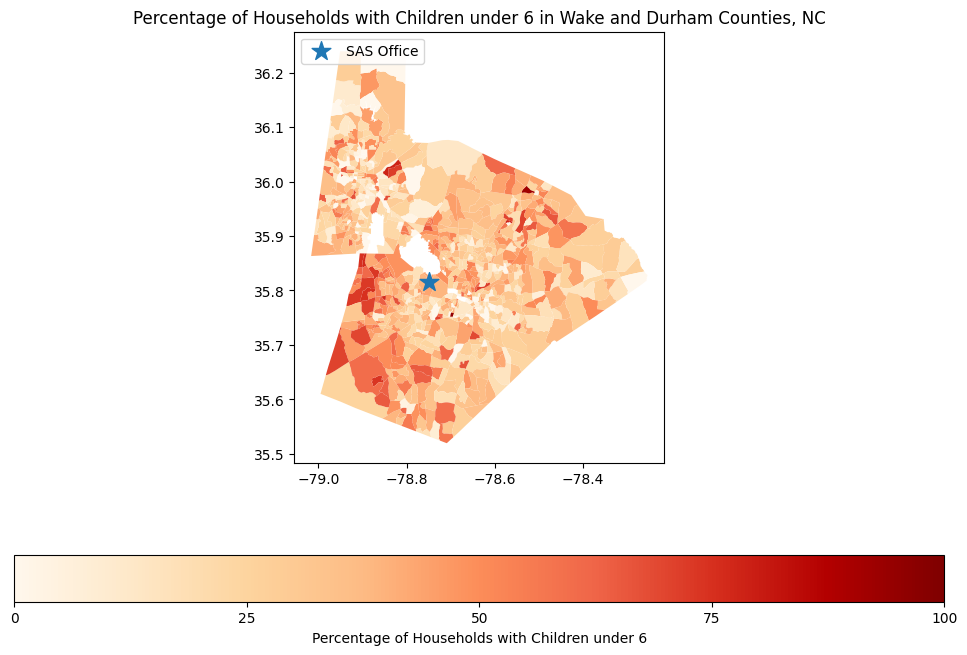

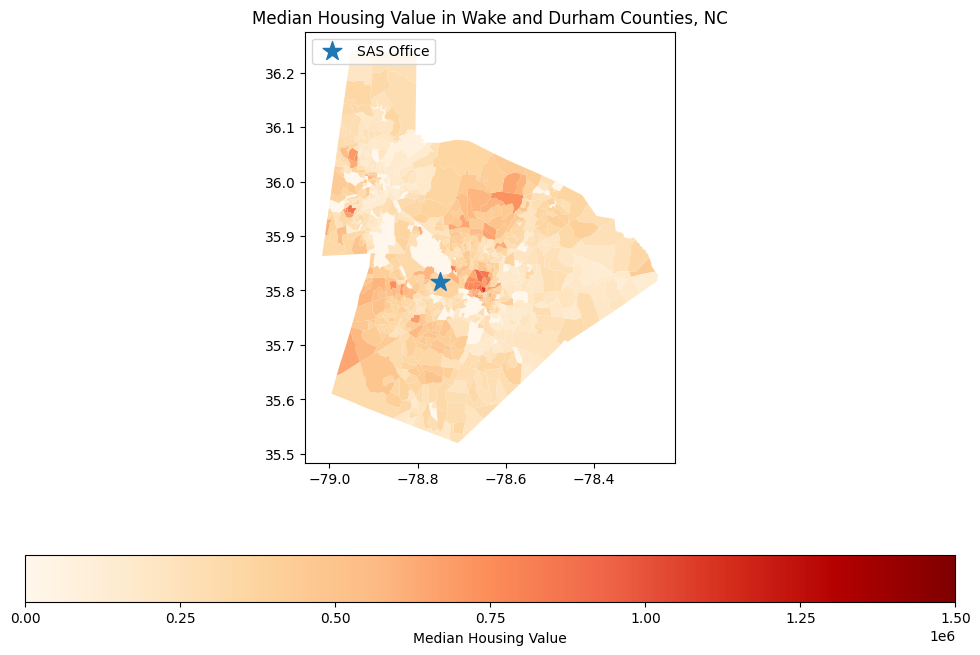

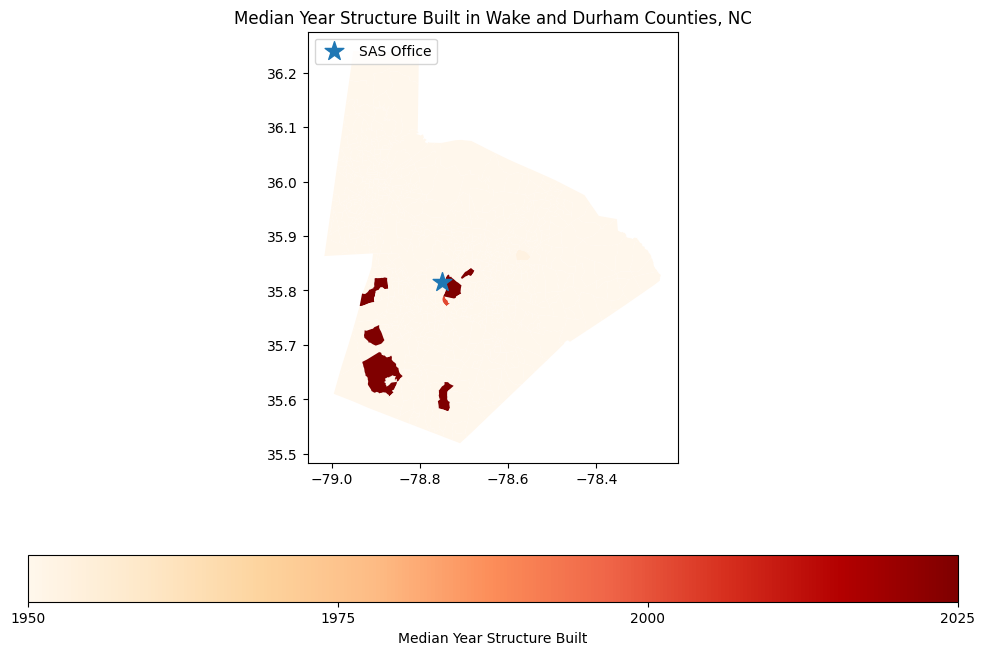

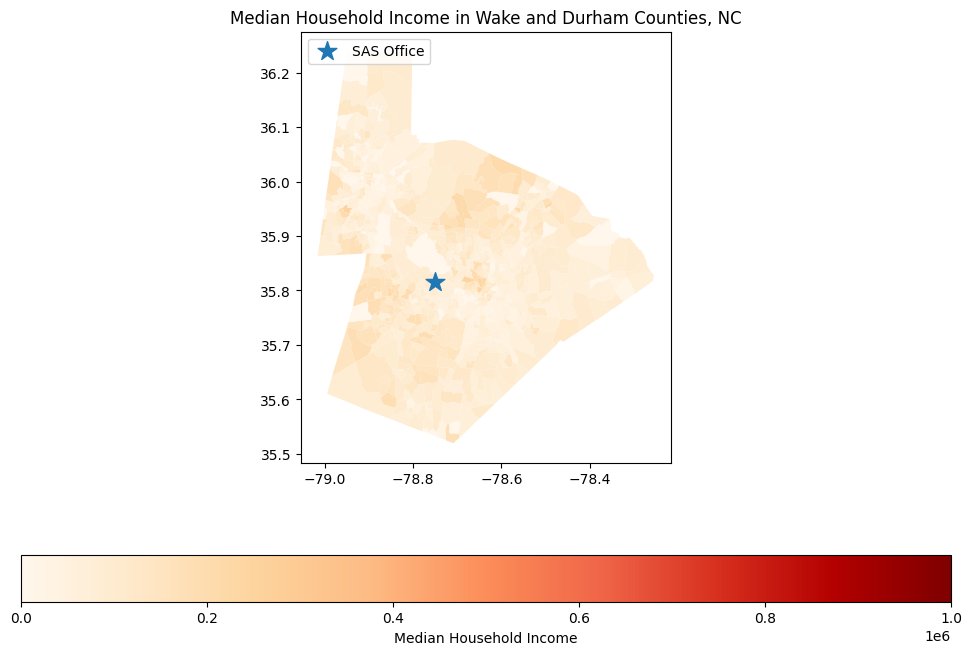

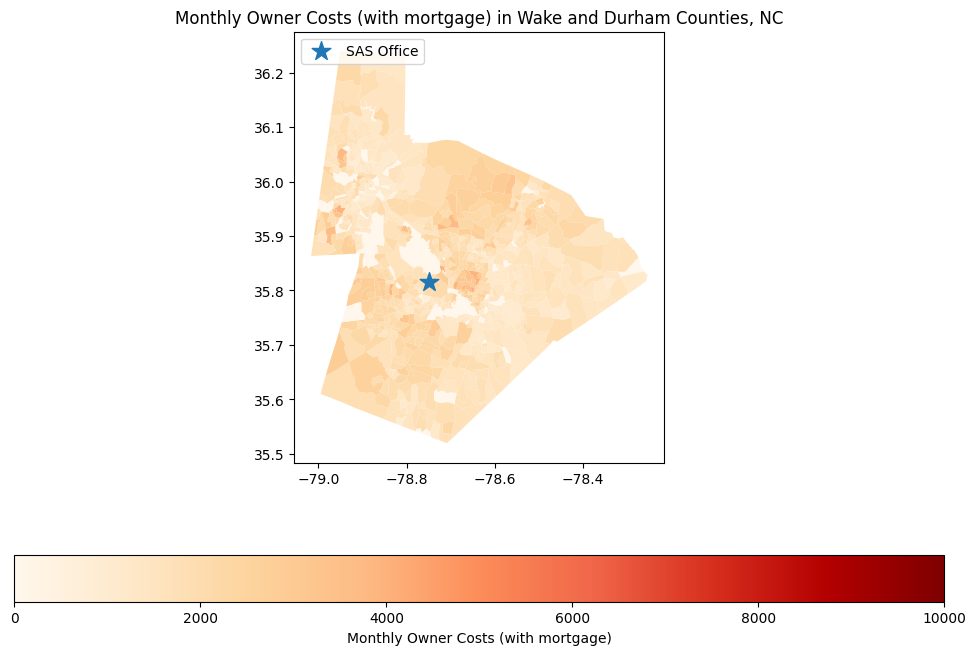

In [7]:
variables = {
    '% Households with Children under 6': 'Percentage of Households with Children under 6',
    'Median Housing Value': 'Median Housing Value',
    'Median Year Structure Built': 'Median Year Structure Built',
    'Median Household Income': 'Median Household Income',
    'Monthly Owner Costs (with mortgage)': 'Monthly Owner Costs (with mortgage)'
}

custom_scales = {
    '% Households with Children under 6': {'vmin': 0, 'vmax': 100, 'ticks': np.arange(0, 101, 25)},
    'Median Housing Value': {'vmin': 0, 'vmax': 1_500_000, 'ticks': np.arange(0, 1_500_001, 250_000)},
    'Median Year Structure Built': {'vmin': 1950, 'vmax': 2025, 'ticks': np.arange(1950, 2026, 25)},
    'Median Household Income': {'vmin': 0, 'vmax': 1_000_000, 'ticks': np.arange(0, 1_000_001, 200_000)},
    'Monthly Owner Costs (with mortgage)': {'vmin': 0, 'vmax': 10_000, 'ticks': np.arange(0, 10_001, 2_000)}
}

# SAS office location: (lon, lat) for plotting
star_lon, star_lat = -78.74939336654782, 35.81563890659871

for var, label in variables.items():
    scale = custom_scales.get(var, {})
    vmin, vmax = scale.get('vmin'), scale.get('vmax')
    ticks = scale.get('ticks')

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    merged_gdf.plot(
        column=var,
        cmap='OrRd',
        legend=True,
        vmin=vmin, vmax=vmax,
        legend_kwds={
            'label': label,
            'orientation': "horizontal",
            'ticks': ticks
        },
        ax=ax
    )

    ax.scatter(star_lon, star_lat, marker='*', s=200, label='SAS Office')
    ax.set_title(f'{label} in Wake and Durham Counties, NC')
    ax.legend(loc='upper left')

    plt.show()



***

### 🚗 Step 8 | How Far Is Each Neighborhood from SAS?

Now we answer the key commute questions:

- How far (in miles) is each block group’s **centroid** from the SAS office?
- If we assume an average speed of **35 mph**, what’s the **estimated travel time**?

    Later students can:
    🎯 Adjust travel weights & constraints  
    🎯 Try different speed assumptions  
    🎯 Explore how commute affects final rankings

This makes optimization **feel real** 💡

This gives us a rough commute metric we’ll later use as a hard constraint (≤ 30 minutes) and as part of the scoring.

Time for time → ⬇️

In [8]:
# SAS office location (lat, lon) for geodesic distance
office_coords = (35.81563890659871, -78.74939336654782)

# Step 1: Re-project to a projected CRS for accurate centroid calculations
merged_gdf = merged_gdf.to_crs(epsg=32119)  # NAD83 / North Carolina

# Step 2: Calculate centroids
merged_gdf['centroid'] = merged_gdf.geometry.centroid

# Step 3: Build a centroids GeoDataFrame in WGS84 for geodesic distance
centroids_geo = merged_gdf.copy()
centroids_geo = centroids_geo.set_geometry('centroid')
centroids_geo = centroids_geo.to_crs(epsg=4326)  # WGS84

# Step 4: Extract (lat, lon) from centroid
centroids_geo['centroid_lat_lon'] = centroids_geo.geometry.apply(
    lambda point: (point.y, point.x)
)

print(centroids_geo[['centroid_lat_lon']].head())

# Step 5: Distance to office (miles)
centroids_geo['Distance to Office (miles)'] = centroids_geo['centroid_lat_lon'].apply(
    lambda coords: geodesic(coords, office_coords).miles
)

# Step 6: Estimated travel time (minutes) assuming average 35 mph
average_speed_mph = 35
centroids_geo['Travel Time to Office (minutes)'] = (
    centroids_geo['Distance to Office (miles)'] / average_speed_mph * 60
)

# Step 7: Merge back onto main GeoDataFrame
merged_gdf = merged_gdf.merge(
    centroids_geo[['GEOID', 'Distance to Office (miles)', 'Travel Time to Office (minutes)']],
    on='GEOID',
    how='left'
)

merged_gdf[['GEOID', 'Distance to Office (miles)', 'Travel Time to Office (minutes)']].head()


                           centroid_lat_lon
0  (35.903340796063844, -78.97281862215833)
1   (35.88311792466788, -78.95813687853575)
2   (36.00591132639148, -78.81109552937917)
3  (35.962512460935805, -78.82855376454891)
4   (35.92500813432616, -78.94154598109864)


,GEOID,Distance to Office (miles),Travel Time to Office (minutes)
0,370630020191,13.921308,23.865100
1,370630020201,12.606907,21.611840
2,370630018061,13.567275,23.258186
3,370630018082,11.057359,18.955473
4,370630020241,13.157935,22.556460



***

### 🌳 Step 9 | Neighborhood Amenities (OSM Goodies)

Census tells us **who** lives there. OpenStreetMap (OSM) helps us see **what’s nearby**.

We’re especially interested in whether each block group has:

- 🛒 A grocery store / supermarket / big-box retail  
- 🌳 A park  
- 🚴 A bike trail

For each block group, we’ll create 0/1 indicator variables:
- `has_grocery_store`
- `has_park`
- `has_bike_trail`

Later, students can add additional amenities to the equation.


In [9]:
import osmnx as ox
import geopandas as gpd

# Ensure CRS is WGS84 (lat/lon) for OSM
merged_gdf = merged_gdf.to_crs(epsg=4326)

# Step 1: Create a unified polygon of the study area
study_area_boundary = merged_gdf.geometry.union_all()

# Step 2: Define amenity queries
amenity_queries = {
    'grocery_store': {
        'amenity': ['supermarket', 'convenience', 'grocery'],
        'shop': ['department_store', 'wholesale']  # e.g., Costco, Sam's, Target, Walmart
    },
    'park': {'leisure': 'park'},
    'bike_trail': {'highway': 'cycleway'}
}

amenity_data = {}

for amenity, tags in amenity_queries.items():
    print(f"Fetching {amenity} from OSM...")
    try:
        amenity_data[amenity] = ox.features_from_polygon(study_area_boundary, tags)
        print(f"  → Retrieved {len(amenity_data[amenity])} features for {amenity}.")
    except Exception as e:
        print(f"  ✖ Error fetching {amenity}: {e}")
        amenity_data[amenity] = gpd.GeoDataFrame()

# Step 3: For each amenity type, mark block groups that intersect any feature
for amenity, amenities_gdf in amenity_data.items():
    col_name = f'has_{amenity}'

    if not amenities_gdf.empty:
        amenities_gdf = amenities_gdf.set_crs(epsg=4326, allow_override=True)

        print(f"Computing intersections for {amenity}...")
        merged_gdf[col_name] = merged_gdf.geometry.apply(
            lambda geom: 1 if not amenities_gdf[amenities_gdf.intersects(geom.buffer(0.001))].empty else 0
        )
    else:
        print(f"No {amenity} features found; setting {col_name} = 0 for all.")
        merged_gdf[col_name] = 0

merged_gdf[['GEOID', 'has_grocery_store', 'has_park', 'has_bike_trail']].head()


Fetching grocery_store from OSM...
  → Retrieved 99 features for grocery_store.
Fetching park from OSM...
  → Retrieved 738 features for park.
Fetching bike_trail from OSM...
  → Retrieved 5467 features for bike_trail.
Computing intersections for grocery_store...
Computing intersections for park...
Computing intersections for bike_trail...


,GEOID,has_grocery_store,has_park,has_bike_trail
0,370630020191,0,0,0
1,370630020201,0,0,1
2,370630018061,0,0,0
3,370630018082,0,1,0
4,370630020241,0,0,1



***

### 💾 Step 10 | Export for Optimization in SAS

Part 2 will use `PROC OPTMODEL` to run our **multi-scenario decision model**.  
So we need to hand this dataset over to SAS:

✔ `CSV` ensures GEOID stays a string  
✔ Easy import into SAS Libraries (`libname` + `proc import`)  

Extra export — SAS7BDAT 📦  
→ helpful for skipping right to modeling in SAS Workbench

> Data prepped in Python → Modeled in SAS → Visualized in R  
> That’s a full **analytics pipeline**! 🔥

Let’s save our work 🚚📦

In [10]:
# -----------------------------------------------------------
# Step 10 — Export merged_gdf as CSV (for SAS to read)
# -----------------------------------------------------------

import re
import os

output_folder = "/workspaces/myfolder/OperationNextNest/Data"
os.makedirs(output_folder, exist_ok=True)

df_export = merged_gdf.copy()

# Drop geometry-like columns
cols_to_drop = [c for c in ['geometry', 'centroid', 'centroid_lat_lon'] if c in df_export.columns]
if cols_to_drop:
    print("Dropping non-tabular columns:", cols_to_drop)
    df_export = df_export.drop(columns=cols_to_drop)

# Make column names SAS-friendly
renamed = {}
for col in df_export.columns:
    new = re.sub(r'[^0-9A-Za-z_]', '_', col)
    if not (new[0].isalpha() or new[0] == '_'):
        new = 'v_' + new
    new = new[:32]
    renamed[col] = new

df_export = df_export.rename(columns=renamed)

csv_path = f"{output_folder}/operation_next_nest.csv"
df_export.to_csv(csv_path, index=False)

print(f"✅ CSV export complete: {csv_path}")
print("Rows, columns:", df_export.shape)


Dropping non-tabular columns: ['geometry', 'centroid']
✅ CSV export complete: /workspaces/myfolder/OperationNextNest/Data/operation_next_nest.csv
Rows, columns: (835, 43)



***

## 🏁 Part 1 Complete | Data Is Power! 💪

🎉 Nice work! You just:

✔ Downloaded real U.S. Census data  
✔ Calculated commute metrics  
✔ Built a spatial dataset for mapping  
✔ Created machine learning/optimization-ready features  
✔ Exported clean files for SAS modeling

Your dataset is now ready for **Part 2** 👇

📈 Next up:  
> Multi-objective optimization with `PROC OPTMODEL` in SAS  
> Where we choose **which neighborhoods rise to the top** under different priorities

Let’s continue the journey in the SAS Notebook → 🚀

***